In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pypdf import PdfWriter

c:\ProgramData\anaconda3\Lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [2]:
with open('jjbeventsthermal.pkl', 'rb') as file:
    events = pickle.load(file)

In [3]:
print(len(events))

693


In [4]:
theEvent=events[182]

In [5]:
print(len(theEvent))

449


229504


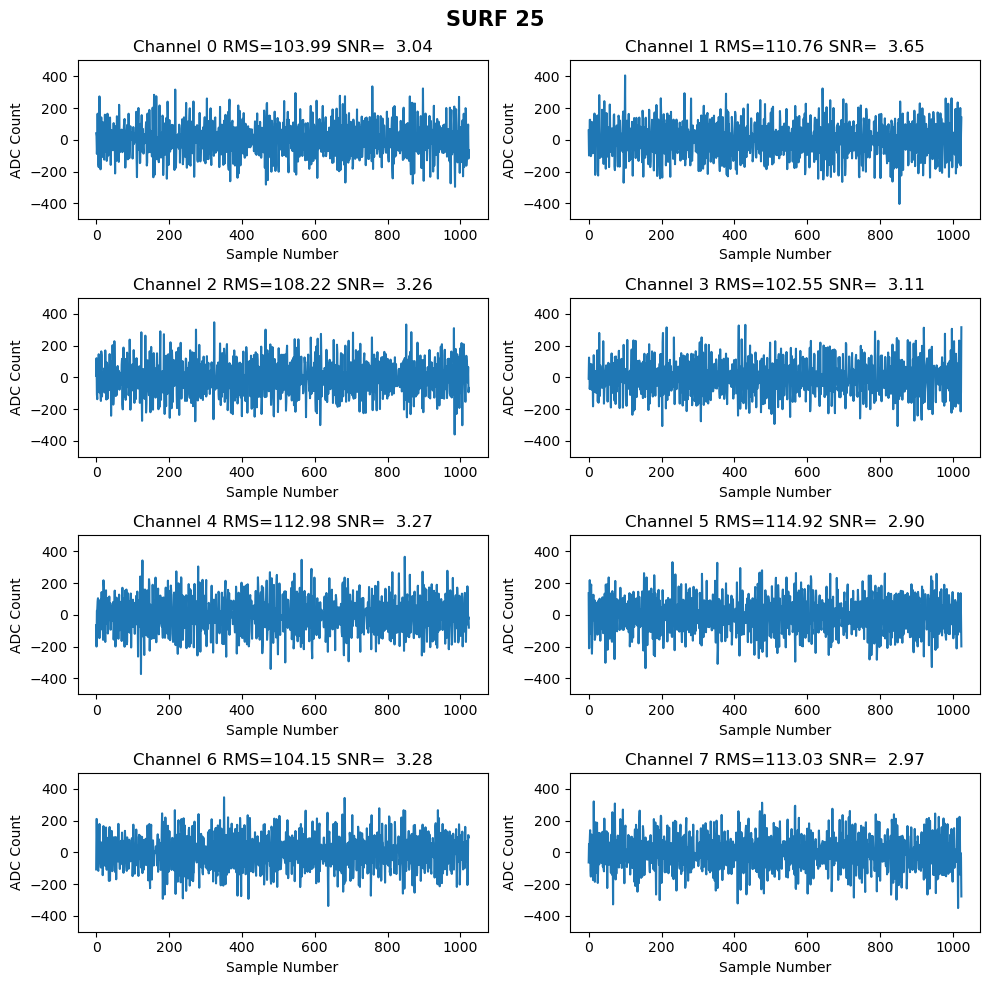

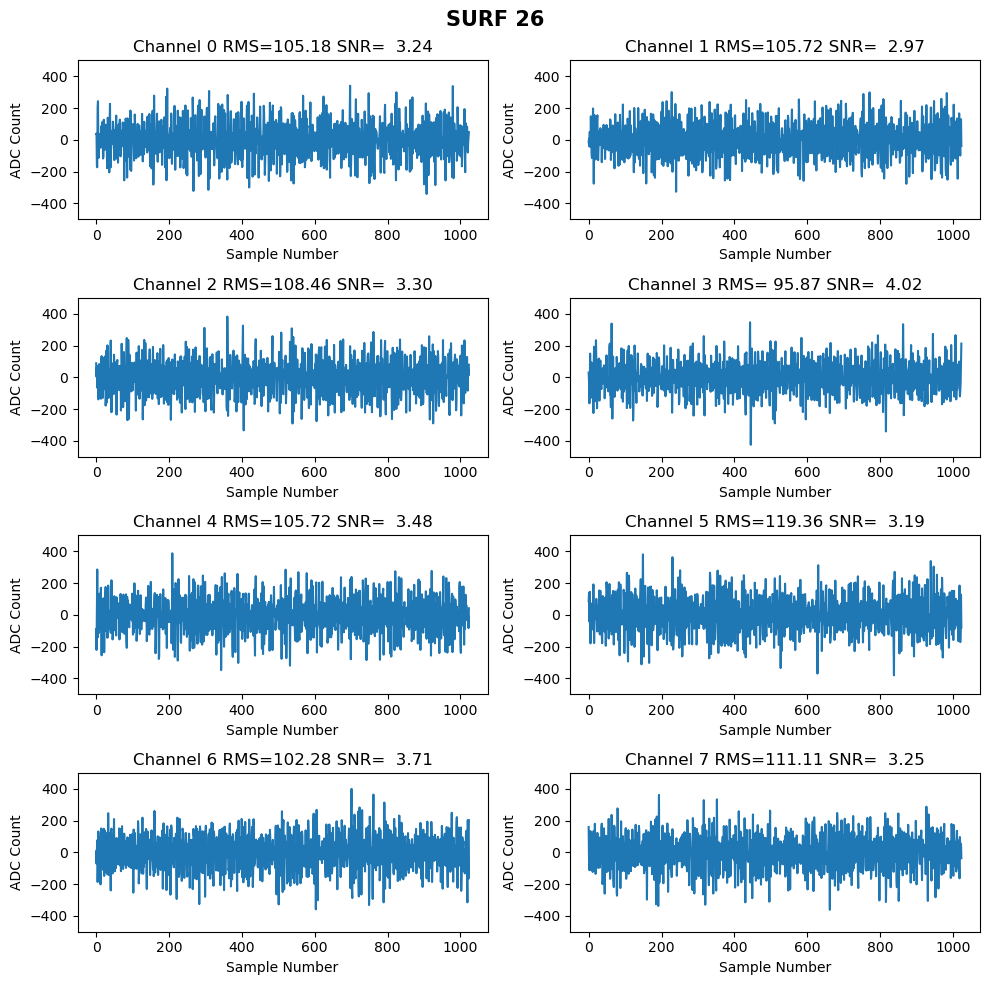

In [6]:
data = np.empty((0))
for i in range(len(theEvent)):
    ## First 8 bytes of each fragments is the header, strip that off (offset = 8) during byte reading and concatenation
    data = np.concatenate((data, np.frombuffer(theEvent[i], dtype = np.int16, offset = 8)))
print(len(data))
## First 128 bytes of data is more headers, remove it
data = data[128:]


## plot entire data stream for quick viewing
#plt.plot(data, linestyle = '-')
#plt.show()

## Reshape to be split into SURF#, Channel#
data = np.reshape(data, (28, 8, 1024))

## Plot all the different surfs and channels on seperate graphs
fn = []
for ii in [25,26]:
    fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=(10,10))

    plt.suptitle('SURF ' + str(ii), fontsize = 15, fontweight = 'bold')
    for i in range(8):
        rms=np.sqrt(np.mean(np.square(data[ii,i,0:256])))
        pkpk=np.max(data[ii,i,:])-np.min(data[ii,i,:])
        snr=0.5*pkpk/rms            
        if (i%2==0):
            axs[i//2, 0].plot(data[ii, i])
            axs[i//2, 0].set_title('Channel ' + str(i) + f" RMS={rms:6.2f} SNR={snr:6.2f}")
            axs[i//2, 0].set_xlabel('Sample Number')
            axs[i//2, 0].set_ylabel('ADC Count')
            axs[i//2, 0].set_ylim(ymin=-500, ymax=500)

        else:
            axs[(i-1)//2, 1].plot(data[ii, i])
            axs[(i-1)//2, 1].set_title('Channel ' + str(i) + f" RMS={rms:6.2f} SNR={snr:6.2f}")
            axs[(i-1)//2, 1].set_xlabel('Sample Number')
            axs[(i-1)//2, 1].set_ylabel('ADC Count')
            axs[(i-1)//2, 1].set_ylim(ymin=-500, ymax=500)
        


    #fig.savefig('test.pdf')
    plt.tight_layout()
    #plt.show()
    filename = './SURF_' + str(ii) + 'data.pdf'
    fig.savefig(filename)
    fn.append(filename)


## Merge all the graphs into a single pdf
merger = PdfWriter()

for pdf in fn:
    merger.append(pdf)

merger.write("test.pdf")
merger.close()
#plt.show()

In [7]:
#delay and sum with beam 5
#NEED TO LOWPASS FILTER FIRST
#ALSO MATCHED FILTER
#DO THESE BEFORE SCALING
delays=[0,13,13,13,1,13,13,13] #BEAM 5
lpk=[-23.,0.,105.,0.,-263.,0.,526.,0.,-949.,0.,1672.,0.,-3216.,0.,10342.,16384.,10342.,0.,-3216.,0.,1672.,0.,-949.,0.,526.,0.,-263.,0.,105.,0.,-23.]
mfk=[ 1,1,-1,-2,1,4,1,-4,-4,0,4,2,0,-2,-2,-1,0,1,2,1,0,-1,-1,-1,0,1,1,1,1,0, -1,-1,-1,0,0,1,1]
for ii in [26,25]:
    delsum=np.zeros(512)
    data = np.apply_along_axis(lambda m: np.convolve(m,lpk, mode='valid'), axis=-1, arr=data)
    print(data.shape)
    data = np.apply_along_axis(lambda m: np.convolve(m,mfk[::-1], mode='valid'), axis=-1, arr=data)
    print(data.shape)
    for i in range(8):
        rms=np.sqrt(np.mean(np.square(data[ii,i,0:200])))
        snippet=data[ii,i,(256-delays[i]):(768-delays[i])]
        snippet=4*snippet/rms
        delsum=delsum+snippet
    delrms=np.sqrt(np.mean(np.square(delsum)))
    #REMEMBER TO SATURATE THE SNIPPETS AT +/- 15.5 AND DO THE WHOLE RECORD (OR MORE THAN MIDDLE HALF)
    #pkpk=np.max(data[ii,i,:])-np.min(data[ii,i,:])
    #snr=0.5*pkpk/rms 
    boxcar=np.ones(16)
    trig=np.convolve(boxcar,np.square(delsum), mode="valid")
    print(len(trig))
    maxtrig=np.max(trig)
    mintrig=np.min(trig)
    print(f"Surf {ii:2d}, Max: {np.max(delsum)}, Min: {np.min(delsum)}, RMS: {delrms:5.2f}, Trig: {maxtrig} {mintrig}") 
    

(28, 8, 994)
(28, 8, 958)
497
Surf 26, Max: 32.896477871934, Min: -35.09456262050873, RMS: 12.33, Trig: 7213.433983247121 350.3835418972802
(28, 8, 928)
(28, 8, 892)
497
Surf 25, Max: 59.23709417061588, Min: -58.096127967039955, RMS: 12.41, Trig: 21366.808662216197 331.08518202252685


In [8]:
print(delsum)

[-3.34168325e+00 -2.82152144e-01  1.89721795e+00  5.66601949e-02
 -1.76298429e+00  1.37778748e+00  5.85600572e+00  3.35490484e+00
 -5.46653773e+00 -8.89695656e+00 -2.28417467e-01  1.01101819e+01
  6.66200240e+00 -8.56222594e+00 -1.54802898e+01 -1.81944793e+00
  1.82358038e+01  1.99092681e+01 -7.21332241e-01 -2.11615430e+01
 -2.00833860e+01 -1.50996761e+00  1.37666764e+01  1.39788965e+01
  5.44257644e+00 -9.57998477e-01 -3.05135320e+00 -5.09147291e+00
 -8.28614820e+00 -8.28425144e+00 -1.39146229e+00  9.05681984e+00
  1.41817135e+01  8.54828676e+00 -3.13378067e+00 -1.07329360e+01
 -9.80502631e+00 -4.49731652e+00  4.92819050e-01  5.11913567e+00
  8.95489405e+00  7.56762737e+00 -4.18387135e-01 -7.42939920e+00
 -5.65420169e+00  8.23936304e-01  1.10041183e+00 -5.43011929e+00
 -6.46147577e+00  4.79997674e+00  1.68015814e+01  1.32003955e+01
 -4.86676229e+00 -1.91705616e+01 -1.66024797e+01 -2.36061702e+00
  1.06453791e+01  1.61108286e+01  1.31442267e+01  7.51772040e-01
 -1.58973921e+01 -2.06563

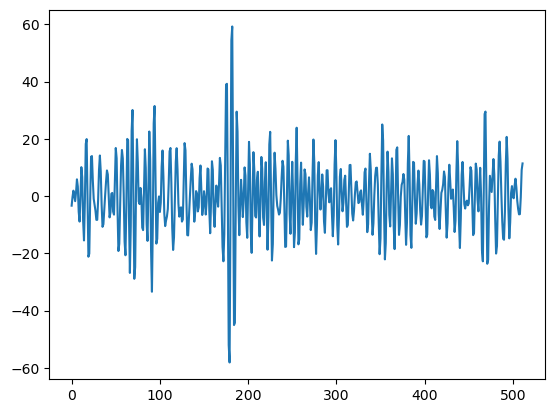

In [9]:
plt.plot(delsum)

In [10]:
print(trig)

[  637.35427897   958.73197317  1355.03132012  1351.95220435
  1799.75989521  2199.99417315  2200.37587701  2355.60445202
  2539.75861303  2539.49721655  2461.25914168  2470.51772348
  2394.22504153  2418.50301746  2413.82012621  2176.11692253
  2254.83251748  2123.40897516  1800.10322487  1809.40348597
  1476.7885005   1169.58464982  1187.53050356   998.25199618
   829.04799874   879.61648787   935.96771085   926.83200229
   956.10487834   919.41462313   851.46467232   850.73941121
   798.19962096   638.8292912    588.79586145   861.26841742
   920.32294299   847.86977729  1195.15435455  1470.55381533
  1449.92077803  1483.05474674  1685.34455928  1857.9402066
  1803.30939537  2024.06647301  2450.07152177  2459.45735346
  2828.84884005  3166.57264458  3199.5720496   3636.61698602
  3573.26900881  4070.9445185   4608.05649002  4333.07608258
  5161.62706565  5662.17547222  5413.06652611  5634.53366254
  5773.36610663  5524.19289937  5105.29115031  5102.89108748
  4704.21381736  4445.990

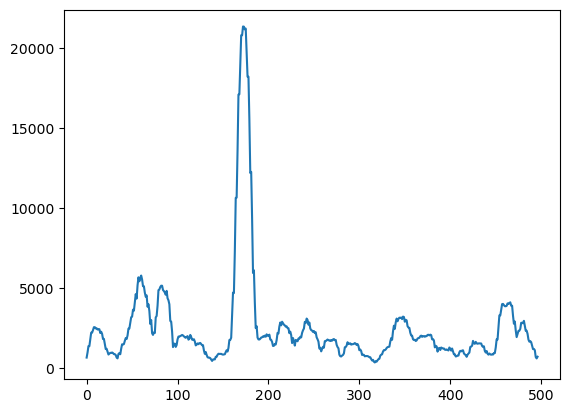

In [11]:
plt.plot(trig)